<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Classification of Reddit Posts

# Problem Statement

##### Is it clear what the goal of the project is?

##### What type of model will be developed?

##### How will success be evaluated?

##### Is the scope of the project appropriate?

##### Is it clear who cares about this or why this is important to investigate?

##### Does the student consider the audience and the primary and secondary stakeholders?

In [ ]:
### PLAN OF ATTACK

# Data Collection

In [229]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import time
import spacy
from wordcloud import WordCloud, STOPWORDS
import re
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
import datetime
import random
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from gensim.models.fasttext import FastText
from gensim.models.keyedvectors import KeyedVectors
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from torch.utils.data import Dataset, DataLoader

#nlp = spacy.load("en_core_web_lg")
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None  # default='warn'

In [17]:
# set parameters
params_zoom = {
    'subreddit': 'zoom',
    'size': 100,
    'after': 1577836800 # after 1 Jan 2020
}

url = 'https://api.pushshift.io//reddit/search/submission'

# get first tranche of data in a list. This retrieves the earliest 100 submissions
res_zoom = requests.get(url, params_zoom)
res_data_zoom = res_zoom.json()['data']

res_data_zoom_add = ['empty']

# update the 'after' params with the latest timestamp and retrieve the next 100 submissions
while len(res_data_zoom_add) > 0:    
    params_zoom['after'] = res_data_zoom[-1]['created_utc']
    res_data_zoom_add = requests.get(url, params_zoom).json()['data']
    res_data_zoom += res_data_zoom_add

In [18]:
# save results to csv
pd.DataFrame(res_data_zoom).to_csv('datasets/zoom_s.csv', index=False)
print(pd.DataFrame(res_data_zoom).shape)

(14794, 87)


In [20]:
# set parameters
params_zoom = {
    'subreddit': 'zoom',
    'size': 100,
    'after': 1577836800 # after 1 Jan 2020
}

url_c = 'https://api.pushshift.io//reddit/search/comment'

# get first tranche of data in a list. This retrieves the earliest 100 comments
res_zoom_c = requests.get(url_c, params_zoom)
res_data_zoom_c = res_zoom_c.json()['data']

res_data_zoom_add_c = ['empty']

# update the 'after' params with the latest timestamp and retrieve the next 100 submissions
while len(res_data_zoom_add_c) > 0:    
    params_zoom['after'] = res_data_zoom_c[-1]['created_utc']
    res_data_zoom_add_c = requests.get(url_c, params_zoom).json()['data']
    res_data_zoom_c += res_data_zoom_add_c

In [21]:
# save results to csv
pd.DataFrame(res_data_zoom_c).to_csv('datasets/zoom_c.csv', index=False)
print(pd.DataFrame(res_data_zoom_c).shape)

(44937, 51)


In [22]:
# set parameters
params_mst = {
    'subreddit': 'MicrosoftTeams',
    'size': 100,
    'after': 1577836800
}

# get first tranche of data in a list. This retrieves the earliest 100 submissions
url = 'https://api.pushshift.io//reddit/search/submission'

res_mst = requests.get(url, params_mst)
res_data_mst = res_mst.json()['data']

res_data_mst_add = ['empty']

# update the 'after' params with the latest timestamp and retrieve the next 100 submissions
while len(res_data_mst_add) > 0:    
    params_mst['after'] = res_data_mst[-1]['created_utc']
    res_data_mst_add = requests.get(url, params_mst).json()['data']
    res_data_mst += res_data_mst_add

In [23]:
# save results to csv
pd.DataFrame(res_data_mst).to_csv('datasets/mst_s.csv', index=False)
print(pd.DataFrame(res_data_mst).shape)

(12632, 91)


In [24]:
# set parameters
params_mst = {
    'subreddit': 'MicrosoftTeams',
    'size': 100,
    'after': 1577836800
}

# get first tranche of data in a list. This retrieves the earliest 100 comments
url_c = 'https://api.pushshift.io//reddit/search/comment'

res_mst_c = requests.get(url_c, params_mst)
res_data_mst_c = res_mst_c.json()['data']

res_data_mst_add_c = ['empty']

# update the 'after' params with the latest timestamp and retrieve the next 100 submissions
while len(res_data_mst_add_c) > 0:    
    params_mst['after'] = res_data_mst_c[-1]['created_utc']
    res_data_mst_add_c = requests.get(url_c, params_mst).json()['data']
    res_data_mst_c += res_data_mst_add_c

In [25]:
# save results to csv
pd.DataFrame(res_data_mst_c).to_csv('datasets/mst_c.csv', index=False)
print(pd.DataFrame(res_data_mst_c).shape)

(61325, 52)


##### Was enough data gathered to generate a significant result?

##### Was data collected that was useful and relevant to the project?

##### Was data collection and storage optimized through custom functions, pipelines, and/or automation?

##### Was thought given to the server receiving the requests such as considering number of requests per second?

# Data Cleaning & EDA

In [183]:
# Read in raw data and perform some basic cleaning
zoom_c = pd.read_csv('datasets/zoom_c.csv', low_memory=False)
zoom_c = zoom_c[zoom_c['author']!= 'AutoModerator']
zoom_c = zoom_c[['created_utc', 'body', 'parent_id', 'subreddit']]
zoom_c['created_utc'] = zoom_c['created_utc'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x))).astype('datetime64[ns]') # convert epoch to local time
zoom_c['parent_id'] = zoom_c['parent_id'].str[3:] # used to join to submission id

mst_c = pd.read_csv('datasets/mst_c.csv', low_memory=False)
mst_c = mst_c[['created_utc', 'body', 'parent_id', 'subreddit']]
mst_c['created_utc'] = mst_c['created_utc'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x))).astype('datetime64[ns]') # convert epoch to local time
mst_c['parent_id'] = mst_c['parent_id'].str[3:] # used to join to submission id

zoom_s = pd.read_csv('datasets/zoom_s.csv', low_memory=False)
zoom_s = zoom_s[['id', 'created_utc', 'selftext', 'title', 'subreddit']]
zoom_s['created_utc'] = zoom_s['created_utc'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x))).astype('datetime64[ns]') # convert epoch to local time

mst_s = pd.read_csv('datasets/mst_s.csv', low_memory=False)
mst_s = mst_s[['id', 'created_utc', 'selftext', 'title', 'subreddit']]
mst_s['created_utc'] = mst_s['created_utc'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x))).astype('datetime64[ns]') # convert epoch to local time

<font color='lightpurple'> For the comment files, the following columns were retained:
- <font color='lightpurple'> created_utc: timestamp of post
- <font color='lightpurple'> body: content
- <font color='lightpurple'> parent_id: Unique Id of the submission under which the comment was posted. We will later on concatenate all comments per submission and join it to the original content of the submission.
- <font color='lightpurple'> subreddit: target variable for the classifier to predict on

<font color='lightpurple'> In addition, through a cursory glance through the Zoom subreddit I found that there are many bot posts under the author "AutoModerator". Since the content of these comments are identical and adds no value, we will remove such comments.

<font color='lightpurple'> For the submission files, the following columns were retained:
- <font color='lightpurple'> id: Unique Id of the submission, used to join the comments
- <font color='lightpurple'> created_utc: timestamp of post
- <font color='lightpurple'> selftext: Description and actual content of the submission
- <font color='lightpurple'> title: Title of submission
- <font color='lightpurple'> subreddit: target variable for the classifier to predict on

### Check for nulls

In [184]:
zoom_s.isnull().sum()

id                0
created_utc       0
selftext       2223
title             0
subreddit         0
dtype: int64

In [185]:
zoom_c.isnull().sum()

created_utc    0
body           0
parent_id      0
subreddit      0
dtype: int64

In [186]:
mst_s.isnull().sum()

id                0
created_utc       0
selftext       2211
title             0
subreddit         0
dtype: int64

In [187]:
mst_c.isnull().sum()

created_utc    0
body           0
parent_id      0
subreddit      0
dtype: int64

<font color='lightpurple'> Only the selftext columns have null values, which is fine because not all submissions have descriptions.

In [188]:
print(f'There is an average of {mst_c.groupby("parent_id")["body"].count().mean()} comments per submission for MST')
print(f'There is an average of {zoom_c.groupby("parent_id")["body"].count().mean()} comments per submission for Zoom')

There is an average of 1.5913691094041935 comments per submission for MST
There is an average of 1.5999021673690548 comments per submission for Zoom


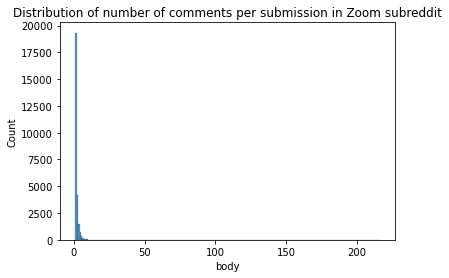

In [189]:
sns.histplot(data=zoom_c.groupby("parent_id")["body"].count().reset_index(), x='body', binwidth=1)
plt.title('Distribution of number of comments per submission in Zoom subreddit')
plt.savefig('Charts/09.jpg')

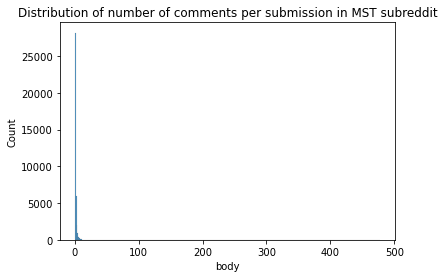

In [190]:
sns.histplot(data=mst_c.groupby("parent_id")["body"].count().reset_index(), x='body', binwidth=1)
plt.title('Distribution of number of comments per submission in MST subreddit')
plt.savefig('Charts/10.jpg')

<font color='lightpurple'> We can see that the majority of reddit submissions have less than 5 comments.

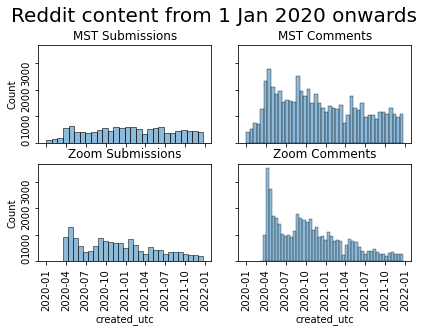

In [191]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
fig.suptitle('Reddit content from 1 Jan 2020 onwards', size=20)
plt.tight_layout()
plt.xticks(rotation=90)

sns.histplot(mst_s['created_utc'], alpha=0.5, ax=ax[0,0])
ax[0,0].tick_params(labelrotation=90)
ax[0,0].title.set_text('MST Submissions')

sns.histplot(mst_c['created_utc'], alpha=0.5, ax=ax[0,1])
ax[0,1].tick_params(labelrotation=90)
ax[0,1].title.set_text('MST Comments')

sns.histplot(zoom_s['created_utc'], alpha=0.5, ax=ax[1,0])
ax[1,0].tick_params(labelrotation=90)
ax[1,0].title.set_text('Zoom Submissions')

sns.histplot(zoom_c['created_utc'], alpha=0.5, ax=ax[1,1])
ax[1,1].tick_params(labelrotation=90)
ax[1,1].title.set_text('Zoom Comments')

fig.savefig('Charts/01.jpg')

<font color='lightpurple'> Based on the time series plot, we observe the following:
- <font color='lightpurple'> There are many more comments than submissions (obviously)
- <font color='lightpurple'> Content on both subreddits spiked from Apr 2020, which corresponds to the period where most countries go into high alert/lockdowns and interactions were shifted online
- <font color='lightpurple'> MST content was sustained throughout the 2 years while Zoom content dwindled over time after the initial spike

<font color='lightpurple'> For the purpose of analysis, we will limit the timeframe to between 1 Apr 2020 and 31 Dec 2020, the period during which most relevant Reddit content would have been generated. 

In [192]:
# Filter time periods to between 1 Apr 2020 and 31 Dec 2020 + further cleaning

zoom_s = zoom_s[(zoom_s['created_utc'] >= '2020-04-01') & (zoom_s['created_utc'] <= '2020-12-31')]

# convert placeholders and NaN to blank string
zoom_s['selftext'] = zoom_s['selftext'].apply(lambda x: '' if x in ('[deleted]', '[removed]', np.nan) else x) 
zoom_s['title'] = zoom_s['title'].apply(lambda x: '' if x in ('[deleted]', '[removed]', np.nan) else x)

# replace \n with white space
zoom_s['selftext'] = zoom_s['selftext'].str.replace('\n', ' ')
zoom_s['title'] = zoom_s['title'].str.replace('\n', ' ')

# remove urls
zoom_s['selftext'] = zoom_s['selftext'].apply(lambda x: re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+', '', str(x)))
zoom_s['title'] = zoom_s['title'].apply(lambda x: re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+', '', str(x)))
zoom_s['text'] = zoom_s[['selftext', 'title']].agg(' '.join, axis=1)
zoom_s = zoom_s.drop(columns = ['selftext', 'title'])

# repeat for mst
mst_s = mst_s[(mst_s['created_utc'] >= '2020-04-01') & (mst_s['created_utc'] <= '2020-12-31')]
mst_s['selftext'] = mst_s['selftext'].apply(lambda x: '' if x in ('[deleted]', '[removed]', np.nan) else x)
mst_s['title'] = mst_s['title'].apply(lambda x: '' if x in ('[deleted]', '[removed]', np.nan) else x)
mst_s['selftext'] = mst_s['selftext'].str.replace('\n', ' ')
mst_s['title'] = mst_s['title'].str.replace('\n', ' ')
mst_s['selftext'] = mst_s['selftext'].apply(lambda x: re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+', '', str(x)))
mst_s['title'] = mst_s['title'].apply(lambda x: re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+', '', str(x)))
mst_s['text'] = mst_s[['selftext', 'title']].agg(' '.join, axis=1)
mst_s = mst_s.drop(columns = ['selftext', 'title'])

zoom_c = zoom_c[(zoom_c['created_utc'] >= '2020-04-01') & (zoom_c['created_utc'] <= '2020-12-31')]
mst_c = mst_c[(mst_c['created_utc'] >= '2020-04-01') & (mst_c['created_utc'] <= '2020-12-31')]

<font color='lightpurple'> DESCRIBE WHY CLEAN THIS WAY, PUNCTUATION/SPECIAL CHAR/STOPWORDS FOR WORD2VEC BUT NOT BERT. TALK ABOUT CASING AS WELL. WHY AGGREGATE SELFTEXT+TITLE

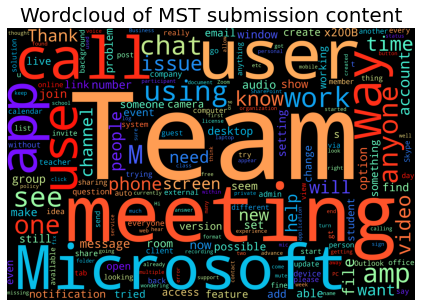

In [193]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(15, 5))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    plt.title('Wordcloud of MST submission content', size=20)
    plt.savefig('Charts/02.jpg')
    
# Generate word cloud
#STOPWORDS.update(['media', 'omitted', 'im', 'image', 'omittedsticker', 'sticker', 'youre', 'omittedimage'])
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='black', colormap='rainbow', collocations=False, 
                      stopwords = STOPWORDS).generate(mst_s['text'].str.cat())
# Plot
plot_cloud(wordcloud)

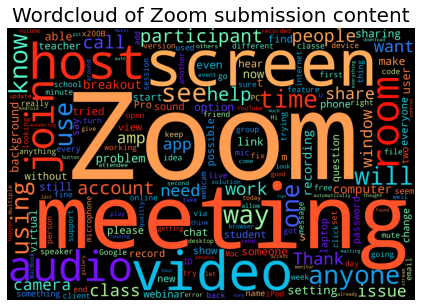

In [194]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(15,5))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    plt.title('Wordcloud of Zoom submission content', size=20)
    plt.savefig('Charts/03.jpg')
    
# Generate word cloud
#STOPWORDS.update(['media', 'omitted', 'im', 'image', 'omittedsticker', 'sticker', 'youre', 'omittedimage'])
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='black', colormap='rainbow', collocations=False, 
                      stopwords = STOPWORDS).generate(zoom_s['text'].str.cat())
# Plot
plot_cloud(wordcloud)

<font color='lightpurple'> Other than the product name, a cursory scan of both wordclouds indicate that some of the terminologies used are very similar, such as "meeting", "use". Some distinction in words include:
- <font color='lightpurple'> Host (Zoom)
- <font color='lightpurple'>Screen (Zoom)
- <font color='lightpurple'>App (MST)
- <font color='lightpurple'>Call (MST)

<font color='lightpurple'> Because the product name is so prominent, we can take advantage of these to summarise comments for each submission, rather than incorporating the text itself. Our text analytics will thus only focus on content from the submission.

### Feature Engineering

<font color='lightpurple'> Our text analytics will largely focus around the submission content, while the comments will be summarised and aggregated into simple numbers, thereby largely disregarding the comment's text.

<font color='lightpurple'> In addition to the word vectors we will generate later on for the submission content, we will also retain simple information from the comments. For each comment, we will calculate the following statistics:
    
|Column|Description|
|---|---|
|has_zoom|Whether the word "zoom" occurs (without "microsoft" or "teams")|
|has_mst|Whether the words "microsoft" or "teams" occur (without "zoom")|
|has_zoom_mst|Whether the comment has both "zoom" and either "microsoft" or "teams"|
|no_zoom_mst|Whether the comment has neither "zoom" nor "microsoft" nor "teams"|    
|char_count|Number of characters of comment|       

<font color='lightpurple'> With these statistics, we will further aggregate to the submission level. Each submission will have the following statistics: 
    
|Column|Description|
|---|---|
|prop_zoom|Proportion of comments that only have "zoom"|    
|prop_mst|Proportion of comments that only have "microsoft" or "teams"|    
|prop_zoom_mst|Proportion of comments that have "zoom" and either "microsoft" or "teams"|    
|prop_no_zoom_mst|Proportion of comments that has neither "zoom" nor "microsoft" nor "teams"|       
|avg_cmt_len|Average length of comments|     
|num_cmts|Number of comments|  

In [195]:
# Define custom function to check whether word(s) is/are in string
def check_word_in_string(s, list_of_words):    
    
    return any(word in s.lower() for word in list_of_words)
    
check_word_in_string('Make sure you have updated Zoom to the most current version.', ['zoom'])

True

In [196]:
combined_c = pd.concat([zoom_c, mst_c]).reset_index().drop(columns = ['index'])

combined_c['has_zoom'] = combined_c['body'].apply(lambda x: 1 if check_word_in_string(x, ['zoom']) and not check_word_in_string(x, ['microsoft', 'teams', 'mst']) else 0)
combined_c['has_mst'] = combined_c['body'].apply(lambda x: 1 if not check_word_in_string(x, ['zoom']) and check_word_in_string(x, ['microsoft', 'teams', 'mst']) else 0)
combined_c['has_zoom_mst'] = combined_c['body'].apply(lambda x: 1 if check_word_in_string(x, ['zoom']) and check_word_in_string(x, ['microsoft', 'teams', 'mst']) else 0)
combined_c['no_zoom_mst'] = combined_c['body'].apply(lambda x: 1 if not check_word_in_string(x, ['zoom']) and not check_word_in_string(x, ['microsoft', 'teams', 'mst']) else 0)
combined_c['char_count'] = combined_c['body'].apply(len)

#mst_c['has_zoom'] = mst_c['body'].apply(lambda x: 1 if check_word_in_string(x, ['zoom']) and not check_word_in_string(x, ['microsoft', 'teams', 'mst']) else 0)
#mst_c['has_mst'] = mst_c['body'].apply(lambda x: 1 if not check_word_in_string(x, ['zoom']) and check_word_in_string(x, ['microsoft', 'teams', 'mst']) else 0)
#mst_c['has_zoom_mst'] = mst_c['body'].apply(lambda x: 1 if check_word_in_string(x, ['zoom']) and check_word_in_string(x, ['microsoft', 'teams', 'mst']) else 0)
#mst_c['no_zoom_mst'] = mst_c['body'].apply(lambda x: 1 if not check_word_in_string(x, ['zoom']) and not check_word_in_string(x, ['microsoft', 'teams', 'mst']) else 0)
#mst_c['char_count'] = mst_c['body'].apply(len)

In [238]:
combined_c_groupby = combined_c.groupby(['subreddit','parent_id'])[['has_zoom', 'has_mst', 'has_zoom_mst', 'no_zoom_mst', 'char_count']].mean().reset_index()
combined_c_groupby['subreddit'] = combined_c_groupby['subreddit'].map({'MicrosoftTeams': 0, 'Zoom':1})
combined_c_groupby

,subreddit,parent_id,has_zoom,has_mst,has_zoom_mst,no_zoom_mst,char_count
0,0,dmp45s,0.0,0.00,0.0,1.00,11.0
1,0,doru03,0.0,0.00,0.0,1.00,28.0
2,0,dqa8ue,0.0,0.00,0.0,1.00,37.0
3,0,dvaxce,0.0,0.00,0.0,1.00,58.0
4,0,dwgdk1,0.0,0.25,0.0,0.75,144.5
...,...,...,...,...,...,...,...
37189,1,kmw5mf,1.0,0.00,0.0,0.00,270.0
37190,1,kmx9ds,0.0,0.00,0.0,1.00,247.0
37191,1,kn1j0g,0.0,0.00,0.0,1.00,301.0
37192,1,kn1vs8,1.0,0.00,0.0,0.00,462.0


<font color='lightpurple'> In the combined_c_groupby dataframe, each row corresponds to the summary statistics of the comments for each submission. For example, in parent_id dwgdk1 (MST), we can say that 25% of the comments have MST tags only while 75% of the comments have neither zoom nor MST tags. Also, the average length of comment is 144.5 characters.
    
<font color='lightpurple'> This dataframe will be concatenated as extra features to the word vectors after vectorising the submission content later on.    

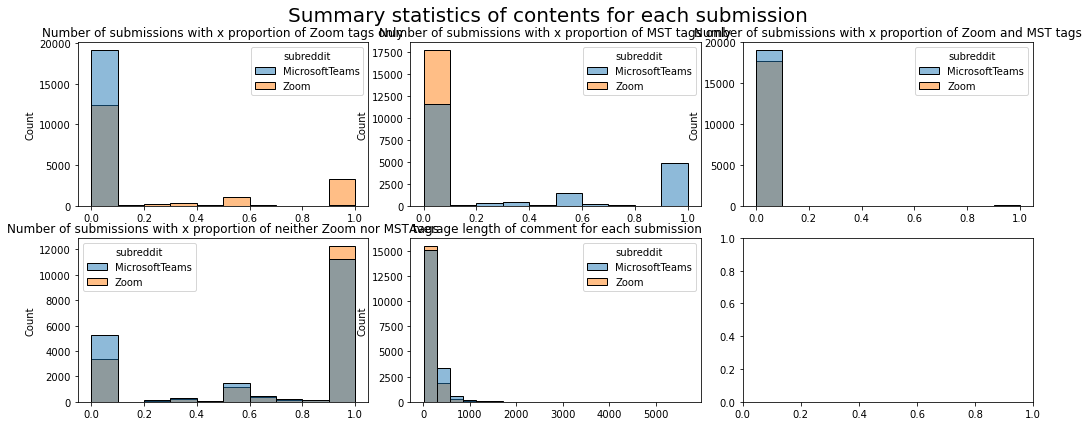

In [198]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize = (14,6))
fig.suptitle('Summary statistics of contents for each submission', size=20)
plt.tight_layout()

sns.histplot(data=combined_c_groupby, x='has_zoom', hue='subreddit', binwidth = 0.1, ax=ax[0,0])
ax[0,0].title.set_text('Number of submissions with x proportion of Zoom tags only')
ax[0,0].set_xlabel('')

sns.histplot(data=combined_c_groupby, x='has_mst', hue='subreddit', binwidth = 0.1, ax=ax[0,1])
ax[0,1].title.set_text('Number of submissions with x proportion of MST tags only')
ax[0,1].set_xlabel('')

sns.histplot(data=combined_c_groupby, x='has_zoom_mst', hue='subreddit', binwidth = 0.1, ax=ax[0,2])
ax[0,2].title.set_text('Number of submissions with x proportion of Zoom and MST tags')
ax[0,2].set_xlabel('')

sns.histplot(data=combined_c_groupby, x='no_zoom_mst', hue='subreddit', binwidth = 0.1, ax=ax[1,0])
ax[1,0].title.set_text('Number of submissions with x proportion of neither Zoom nor MST tags')
ax[1,0].set_xlabel('')

sns.histplot(data=combined_c_groupby, x='char_count', hue='subreddit', bins=20, ax=ax[1,1])
ax[1,1].title.set_text('Average length of comment for each submission')
ax[1,1].set_xlabel('')

fig.savefig('Charts/11.jpg')

In [199]:
combined_c_groupby.groupby('subreddit')[['has_zoom', 'has_mst', 'has_zoom_mst', 'no_zoom_mst', 'char_count']].mean()

,has_zoom,has_mst,has_zoom_mst,no_zoom_mst,char_count
subreddit,,,,,
MicrosoftTeams,0.008188,0.321609,0.010295,0.659907,203.945763
Zoom,0.236783,0.002929,0.004961,0.755327,149.757709


<font color='lightpurple'> From the top left histogram, majority of the MST submissions have comments which do not contain Zoom tags only. On the other hand, there are about 3000 Zoom submissions which have a large proportion of their comments with Zoom tags only.
    
<font color='lightpurple'> As the histograms are not so interpretable, averaging the proportions might be more meaningful as we can see in the summary table above. We see that for MST, on average, 32% of the comments for each submission contains MST tags only, while 66% of the comments do not mention either Zoom or MST. For Zoom, on average, 24% of the comments for each submission contains Zoom tags only, while 76% of the comments do not mention either Zoom or MST. The average comment length is also higher for MST as compared to Zoom.
    
<font color='lightpurple'> In other words, we can postulate that given a particular submission, if a higher proportion of its comments are geared toward a certain tag, it is more likely that the submission is from that subreddit. This is of course, a no-brainer, but  we can see that 'has_zoom' and 'has_mst' might be potentially useful features in our machine learning model. We will proceed to drop the other 3 features since they do not show obvious distinctions in distribution vis-a-vis the 2 subreddits and are unlikely to be useful.

In [242]:
combined_c_groupby.drop(columns=['has_zoom_mst', 'no_zoom_mst', 'char_count'], inplace=True)

In [207]:
# Choose 5155 rows at random from Zoom submission dataframe
random_integers = np.random.choice(range(0,8528), size=5155, replace=False).tolist()

zoom_s = zoom_s.sort_values('created_utc').reset_index().drop(columns=['index'])
zoom_s = zoom_s.iloc[random_integers, :]
print(zoom_s.shape)

combined_s = pd.concat([zoom_s, mst_s]).reset_index()
print(combined_s.shape)

# Dummify target variable
combined_s['subreddit'] = combined_s['subreddit'].map({'MicrosoftTeams': 0, 'Zoom': 1})

(5155, 4)
(10310, 5)


<font color='lightpurple'> The unbalanced classes (8528 Zoom vs 5155 MST) may result in the model not having sufficient data to predict the underrepresented class, hence we will randomly undersample the overrepresented class (Zoom) to ensure that the classes are equal. This will also allow the timeframe for each to be kept consistent. Each row will now correspond to a submission with all its corresponding comments. The total row count is the total number of zoom and MST submissions

### Has the submission content changed over time?

In [232]:
# Do word count for top 10 words in Zoom and MST submissions via manual tokenizing

# manual tokenizing on space and punctuation and remove stopwords.
combined_s['text_nostop'] = combined_s['text'].apply(lambda x: ' '.join([i for i in RegexpTokenizer('[\s,;\'\.]+', gaps=True).tokenize(x) if i.lower() not in stopwords.words('english')]))

# 1. Filter to respective month and subreddits
# 2. Extract text_nostop column and string concatenate all rows into one long string
# 3. Tokenize into list of words
apr_zoom_words = RegexpTokenizer('[\s,;\'\.]+', gaps=True).tokenize(combined_s[(combined_s['created_utc'].dt.month == 4) & (combined_s['subreddit'] == 1)]['text_nostop'].str.cat())
dec_zoom_words = RegexpTokenizer('[\s,;\'\.]+', gaps=True).tokenize(combined_s[(combined_s['created_utc'].dt.month == 12) & (combined_s['subreddit'] == 1)]['text_nostop'].str.cat())

apr_mst_words = RegexpTokenizer('[\s,;\'\.]+', gaps=True).tokenize(combined_s[(combined_s['created_utc'].dt.month == 4) & (combined_s['subreddit'] == 0)]['text_nostop'].str.cat())
dec_mst_words = RegexpTokenizer('[\s,;\'\.]+', gaps=True).tokenize(combined_s[(combined_s['created_utc'].dt.month == 12) & (combined_s['subreddit'] == 0)]['text_nostop'].str.cat())

# String all content together, then tokenize with space as separator
#words_zoom = RegexpTokenizer('\s+', gaps=True).tokenize(combined_s[combined_s['subreddit'] == 1]['text'].str.cat())

# Remove stopwords
#words_zoom_nostop = [i for i in words_zoom if i.lower() not in stopwords.words('english')]

#words_mst = RegexpTokenizer('\s+', gaps=True).tokenize(combined_s[combined_s['subreddit'] == 0]['text'].str.cat())
#words_mst_nostop = [i for i in words_mst if i.lower() not in stopwords.words('english')]

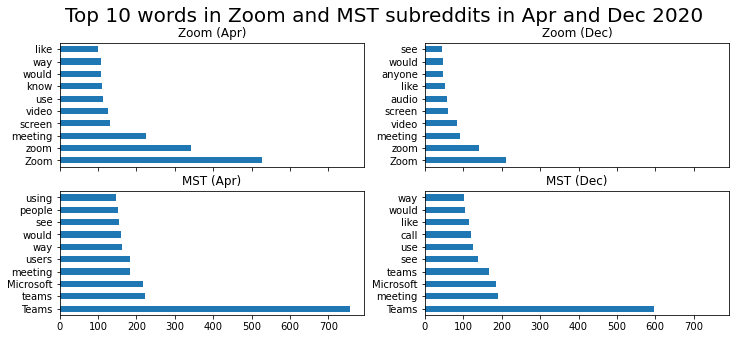

In [234]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,5), sharex=True)
plt.suptitle('Top 10 words in Zoom and MST subreddits in Apr and Dec 2020', size=20)

# Use Counter to count number of occurrences of each word, then put results in a dictionary, then a Series
# Sort the series by word count and take the top 10 most occurring
pd.Series(dict(Counter(apr_zoom_words))).sort_values(ascending=False)[:10].plot.barh(ax=ax[0,0])
ax[0,0].title.set_text('Zoom (Apr)')
pd.Series(dict(Counter(dec_zoom_words))).sort_values(ascending=False)[:10].plot.barh(ax=ax[0,1])
ax[0,1].title.set_text('Zoom (Dec)')
pd.Series(dict(Counter(apr_mst_words))).sort_values(ascending=False)[:10].plot.barh(ax=ax[1,0])
ax[1,0].title.set_text('MST (Apr)')
pd.Series(dict(Counter(dec_mst_words))).sort_values(ascending=False)[:10].plot.barh(ax=ax[1,1])
ax[1,1].title.set_text('MST (Dec)')

fig.savefig('Charts/05.jpg')

<font color='lightpurple'> Based on the top 10 words, there does not seem to be a distinct change in words used between Apr and Dec, for both Zoom and MST subreddits

In [286]:
# Save cleaned data as csv
combined_s[['id', 'created_utc', 'subreddit', 'text', 'text_nostop']].to_csv('datasets/cleaned_submission.csv', index=False)
combined_c_groupby.to_csv('datasets/cleaned_comments.csv', index=False)

##### Are missing values imputed/handled appropriately?

##### Are distributions examined and described?

##### Are outliers identified and addressed?

##### Are appropriate summary statistics provided?

##### Are steps taken during data cleaning and EDA framed appropriately?

##### Does the student address whether or not they are likely to be able to answer their problem statement with the provided data given what they've discovered during EDA?

<font color='lightpurple'> Based on our EDA so far, even with stopwords removed, it is difficult to tell if the content would be sufficient to adequately differentiate the two subreddits. There are however, some telling signs such as the presence of Zoom or MST tags. Based on this, it would seem that vectorizers such as Count or Tfidf would do well here.

# Preprocessing & Modeling

<font color='lightpurple'> In order for machine learning to be applied to text, the text needs to be first converted into numbers, a process known as vectorisation. There are many different ways of vectorisation ranging in terms of complexity.
    
<font color='lightpurple'> In this project, we will explore 3 different vectorisation methods and see which produces the best results. These are:
- <font color='lightpurple'> TfidfVectorizer    
- <font color='lightpurple'> Word2Vec
- <font color='lightpurple'> BERT 
    
<font color='lightpurple'> We will also test 2 different machine learning models to see which is able to best distinguish the subreddit contents. These are:
- <font color='lightpurple'> LogisticRegression
- <font color='lightpurple'> RandomForest
- <font color='lightpurple'> MultiLayer Perceptron Classifier    
    
<font color='lightpurple'> Because of the differences in how the 3 word vectorizers vectorisers the text, we need to perform further text cleaning in different ways, such as deciding whether to remove stopwords and/or lemmatize the text. When performing text analytics, it is important to ensure that words of similar meanings are grouped together to avoid duplication, as in the case of 'run', 'ran', 'running'. Two popular methods are Porter Stemmer and Lemmatization. Both methods attempt to return a given word to its root word, or lemma, but does so in a different way. It is also worth noting that neither are able to correct spelling errors. This might throw our model off if such errors occur in large quantities.

<font color='lightpurple'> Porter Stemmer is a rule-based method that removes word prefixes and suffixes in a pre-determined fashion. It is fast, although the resulting word may not be an english word. For example, stemming 'computer' results in 'comput'. It is also rather blunt, as stemming 'computation' also results in 'comput', although both words might have different meanings. Lemmatization on the other hand, is a softer approach and takes the context of the word into account. However, it is computationally more expensive. As we want our model to be as accurate and interpretable as possible, we will go with lemmatization instead where appropriate.
    
<font color='lightpurple'> **TfidfVectorizer** is an improvement over the standard CountVectorizer, where the occurrence of a word in the document is compared to its occurrences over the whole corpus. For example, if the word 'computer' occurs frequently in one submission but doesn't occur again elsewhere, we can say that 'computer' is likely to be very important to that sentence. On the other hand, words like 'that' are generic and probably occur in every document, hence less weightage will be assigned to this word. The mathematical formula to calculate Tfidf is such that the resulting value might be a decimal, and the resulting dataframe has the same number of rows as the number of submissions, and the number of columns equal to the number of unique words. As such, the following preprocessing will need to be applied when using TfidfVectorizer:
- <font color='lightpurple'> Removal of punctuation, special characters and stopwords: These add no value to the overall meaning of the document. While the formula of Tfidf would already neglect these items naturally, it would be good to remove them anyway.
- <font color='lightpurple'> Lemmatization: Since the vectorizer does not take into account the meaning of the word, we'll need to group similar words together via Lemmatization to avoid duplication of words of similar meanings.     
- <font color='lightpurple'> Casing: Word casings should be standardized to lower case to avoid duplication of words with similar meanings.     
    
<font color='lightpurple'> **Word2Vec** is a better way at deciphering word meanings and seeks to decompose every word into an n-dimensional array, such that words of similar meaning would be close together in n-dimensional space. Sentences can then be aggregated by taking the average of the arrays of the individual words. This might mean that two sentences which are in complete reverse in order would also end up with the same aggregated vector, which sounds odd. However, in practice, this method still works relatively well despite this theoretical drawback. The process of assigning vectors to each word is done by using a pre-trained model [(link)](https://github.com/RaRe-Technologies/gensim-data) which has trained on a Google news dataset containing 100 billion words. Since the language is the same (English) and the use of language is not significantly different from the Google news dataset, using the pre-trained model would save us hundreds of hours of training time without sacrifice in accuracy. A disadvantage of Word2Vec is that unusual words and spelling errors cannot be recognised and have to be manually removed prior to vectorisation. It is also unaware of the context, such as 'bank' as in a financial bank vs a river bank. The aforementioned pre-trained model decomposes words into 300-D arrays and as such, our resulting dataframe would have the same number of rows as the number of submissions, and 300 columns. We will apply the following preprocessing method for Word2Vec:
- <font color='lightpurple'> Removal of punctuation, special characters and stopwords: As these do not add meaning to the sentence, having them would dilute the overall meaning of the sentence. Hence we should remove these.
- <font color='lightpurple'> Lemmatization: Words such as 'run' and 'ran', though similar, will have slightly different vectors which may contribute to the overall meaning of the sentence. For this project, we will not lemmatize the text to retain its original meaning.
- <font color='lightpurple'> Casing: This is abit of a double-edged sword where casing can both help and hurt in determining the overall meaning of the sentence. For example, in this model, 'zoom' and 'Zoom' are recognised differently, with the model being able to pick up the fact that the latter is the videoconferencing platform. Standardising casing would lose this distinction. On the other hand, typo errors such as 'zooM' would cause the model to be completely unable to recognise the word and force us to discard it. For this project, we will retain the original casing as it is more important that the true meaning is captured.
    
<font color='lightpurple'> **BERT** is an even more advanced method to vectorize text. It involves neural networks and, rather than decomposing each word into vectors, BERT is able to take the entire sentence, stopwords and punctuation together and figure out its context of every single word. Hence, the 'bank' in financial banks and river banks would have different vector arrays. For this project, we will use DistilBert, a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances. We will also use the pre-trained model 'distilbert-base-uncased' to save us training time. The output of DistilBert is an N x 768-dimension array, where N is the number of tokens. We will be using the inbuilt [CLS] token as the document average vector (other methods involve averaging the word vectors as in Word2Vec, or taking the weighted average by Tfidf). Because BERT is context-dependent, we will not perform any further preprocessing for this, to avoid confusing the model.     

||TfidfVectorizer|Word2Vec|BERT|
|---|---|---|---|
|Removal of punctuation, special characters and stopwords|Y|Y|N|
|Lemmatization|Y|N|N|
|Standardised casing|Y|N|N|

### Process submission text for each vectoriser separately

In [2]:
lemmatizer = WordNetLemmatizer()

cmts = pd.read_csv('datasets/cleaned_comments.csv')

df = pd.read_csv('datasets/cleaned_submission.csv')
df = df.dropna(subset=['text_nostop']).reset_index().drop(columns='index')
df.columns = ['ids', 'created_utc', 'subreddit', 'text', 'text_nostop'] # as tfidf count also has the word 'id'
df = df[df['text'] != ' ']

### TfidfVectorizer

In [3]:
def preprocess_tfidf(dataframe,
                     lower_case=True,
                     remove_special_punc=True,
                     lemmatize=True,
                     ngram_range=(1,1), max_df=1.0, min_df=1, max_features=None):
    '''
    Takes in a dataframe including the text, performs train-test split followed by vectorization
    Default Arguments only applicable for TfidfVectorizer
    '''
    
    # Preprocess text first
    df_tfidf = dataframe[['ids', 'subreddit', 'text_nostop']]
    
    if lower_case:
        df_tfidf['text_nostop'] = df_tfidf['text_nostop'].str.lower() #lower case
    
    if remove_special_punc:
        df_tfidf['text_nostop'] = df_tfidf['text_nostop'].str.replace('[^0-9a-zA-Z\s]','') #remove special char, punctuation
    
    if lemmatize:
        df_tfidf['text_nostop'] = df_tfidf['text_nostop'].apply(lambda x: ' '.join([lemmatizer.lemmatize(i) for i in x.split()])) #lemmatize
    
    tfvec = TfidfVectorizer(ngram_range=ngram_range,
                           max_df=max_df,
                           min_df=min_df,
                           max_features=max_features)
    
    tfvec_X_train, tfvec_X_test, tfvec_y_train, tfvec_y_test = train_test_split(df_tfidf[['ids', 'text_nostop']], df_tfidf['subreddit'],
                                                                                test_size=0.33, random_state=42)

    tfvec_X_train_id = tfvec_X_train['ids'].reset_index(drop=True)
    
    # Vectorise training text data
    tfvec_X_train_text = tfvec.fit_transform(tfvec_X_train['text_nostop'])
    print(f'Shape of tfidf X_train_text: {tfvec_X_train_text.shape}')

    # Add back in id column, since the order of the rows is the same
    tfvec_X_train_text_id = pd.concat([tfvec_X_train_id, 
               pd.DataFrame(tfvec_X_train_text.todense(), columns=tfvec.get_feature_names())]
              , axis=1)
    print(f'Shape of tfidf X_train_text_id: {tfvec_X_train_text_id.shape}')

    
    # Merge in comment data
    tfvec_X_train_final = tfvec_X_train_text_id.merge(cmts, how='left', left_on = 'ids', right_on = 'parent_id').drop(columns = ['subreddit_y', 'parent_id'])
    tfvec_X_train_final.fillna(0, inplace=True)
    tfvec_X_train_final.drop(columns='ids', inplace=True)
    print(f'Shape of tfidf X_train_final: {tfvec_X_train_final.shape}')
    print(f'Shape of tfidf y_train: {tfvec_y_train.shape}')
    
    # Repeat for test text data
    
    tfvec_X_test_id = tfvec_X_test['ids'].reset_index(drop=True)

    tfvec_X_test_text = tfvec.transform(tfvec_X_test['text_nostop'])
    print(f'Shape of tfidf X_test_text: {tfvec_X_test_text.shape}')

    tfvec_X_test_text_id = pd.concat([tfvec_X_test_id, 
               pd.DataFrame(tfvec_X_test_text.todense(), columns=tfvec.get_feature_names())]
              , axis=1)
    print(f'Shape of tfidf X_test_text_id: {tfvec_X_test_text_id.shape}')

    tfvec_X_test_final = tfvec_X_test_text_id.merge(cmts, how='left', left_on = 'ids', right_on = 'parent_id').drop(columns = ['subreddit_y', 'parent_id'])
    tfvec_X_test_final.fillna(0, inplace=True)
    tfvec_X_test_final.drop(columns='ids', inplace=True)
    print(f'Shape of tfidf X_test_final: {tfvec_X_test_final.shape}')
    print(f'Shape of tfidf y_test: {tfvec_y_test.shape}')
    
    return tfvec_X_train_final, tfvec_X_test_final, tfvec_y_train, tfvec_y_test

### Word2Vec

In [73]:
# once-off download
# w2v = api.load("word2vec-google-news-300")
# ft = api.load("fasttext-wiki-news-subwords-300")

# Once off save model

#w2v.save('models/word2vec')
#ft.save('models/fasttext')

In [4]:
w2v = KeyedVectors.load('models/word2vec')
#ft = KeyedVectors.load('models/fasttext')

### Visualising Word2Vec word vectors

<font color='lightpurple'> It is difficult for us to visualise a vector space of 300 dimensions to get a sense of how "close" words are, but we can employ Principle Component Analysis (PCA) to decompose the 300 dimensions into the 2 principle components such that we can view it in 2-d space. PCA is a linear dimensionality reduction technique that strives to preserve as much information as possible within a fewer number of dimensions. It is useful for feature reduction and visualising high dimension data, but the downside is that the resulting features are no longer interpretable. There is also no need to scale the data as Word2Vec already puts the vectors in the same scale.
    
<font color='lightpurple'> We have chosen the top 10 words from the earlier word count (manual) in Zoom and MST subreddits to see if these words can be distinguish properly and hence provide some clue as to how successful our model may be.

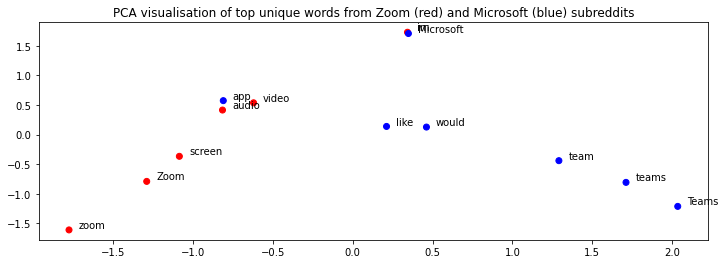

In [5]:
from sklearn.decomposition import PCA

# 14 unique words that only appear in either Zoom or MST
zoom_mst_words = ['Zoom', 'zoom', 'screen', 'video', 'audio', 'im', 'teams', 'Microsoft', 'app', 'would', 'team', 'like', 'Teams']

word_vectors = w2v[zoom_mst_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)

plt.figure(figsize=(12, 4))
plt.scatter(p_comps[:, 0], p_comps[:, 1], c=['red']*6 + ['blue']*7)
plt.title('PCA visualisation of top unique words from Zoom (red) and Microsoft (blue) subreddits')

for word_names, x, y in zip(zoom_mst_words, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')
    
plt.savefig('Charts/08.jpg')    

<font color='lightpurple'> Well how about that! We can see that the distinction between the words from Zoom subreddit and words from MST subreddit are quite nicely divided, with the exception of "app" and "im". This is indeed a promising sign that the content between the 2 subreddits are distinct enough to be picked up by our models

In [6]:
w2v_vocab = set(w2v.index_to_key)

def preprocess_w2v(dataframe,
                     lower_case=True,
                     remove_special_punc=True,
                     lemmatize=True):
    '''
    Takes in a dataframe including the text, performs vectorization followed by train_test_split
    '''
    
    # Merge with comments statistics
    df_w2v = dataframe[['ids', 'subreddit', 'text_nostop']].merge(cmts, how='left', left_on='ids', right_on='parent_id')
    df_w2v = df_w2v.drop(columns=['subreddit_y', 'parent_id', 'ids'])
    
    # Check nulls only for cmts columns
    print(df_w2v.isnull().sum())
    df_w2v.fillna(0, inplace=True)
    
    if lower_case:
        df_w2v['text_nostop'] = df_w2v['text_nostop'].str.lower() #lower case
    
    if remove_special_punc:
        df_w2v['text_nostop'] = df_w2v['text_nostop'].str.replace('[^0-9a-zA-Z\s]','') #remove special char, punctuation
    
    if lemmatize:
        df_w2v['text_nostop'] = df_w2v['text_nostop'].apply(lambda x: ' '.join([lemmatizer.lemmatize(i) for i in x.split()])) #lemmatize
    
    # Remove OOV words
    df_w2v['text_noOOV'] = df_w2v['text_nostop'].apply(lambda x: ' '.join([i for i in x.split() if i in w2v_vocab]))

    # Remove rows with blank string
    df_w2v = df_w2v[df_w2v.text_noOOV != ''].reset_index(drop=True)
    print(f'Shape of df_w2v: {df_w2v.shape}')
    
    # Vectorise text and store in new dataframe. Sentence vector = average of word vectors
    df_w2v_vectors = pd.DataFrame(df_w2v['text_noOOV'].apply(lambda x: np.mean([w2v[i] for i in x.split()], axis=0)).values.tolist())
    print(f'Shape of df_w2v_vectors: {df_w2v_vectors.shape}')
    
    # Further merge in word vectors
    df_w2v_final = pd.concat([df_w2v, df_w2v_vectors], axis=1)
    print(f'Shape of df_w2v_final: {df_w2v_final.shape}')
    
    # train test split
    w2v_X_train, w2v_X_test, w2v_y_train, w2v_y_test = train_test_split(df_w2v_final.drop(columns=['subreddit_x', 'text_nostop', 'text_noOOV']), df_w2v_final['subreddit_x'], test_size=0.33, random_state=42)

    print(f'Shape of w2v_X_train: {w2v_X_train.shape}')
    print(f'Shape of w2v_y_train: {w2v_y_train.shape}')
    print(f'Shape of w2v_X_test: {w2v_X_test.shape}')
    print(f'Shape of w2v_y_test: {w2v_y_test.shape}')
    
    return w2v_X_train, w2v_X_test, w2v_y_train, w2v_y_test

### BERT

In [7]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

#encoded_input.input_ids[0]
#tokenizer.decode(list(encoded_input.input_ids[0]))
#encoded_input.attention_mask

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
class CustomTextDataset(Dataset):
    def __init__(self, text, label, tokenizer, max_len):
        self.text = text
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        inputs = self.tokenizer(
            text=self.text[idx],
            return_tensors='pt',
            max_length=self.max_len,
            padding='max_length',
            truncation=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        
        return {
            'ids': ids,
            'mask': mask
        }

In [9]:
def preprocess_bert(dataframe, batch_size=2):
    '''
    Takes in a dataframe including the text, performs vectorization followed by train_test_split
    '''
    # Merge with comments statistics
    df_bert = dataframe[['ids', 'subreddit', 'text']].merge(cmts, how='left', left_on='ids', right_on='parent_id')
    df_bert = df_bert.drop(columns=['subreddit_y', 'parent_id', 'ids'])
    
    # Check nulls only for cmts columns
    print(df_bert.isnull().sum())
    df_bert.fillna(0, inplace=True)
    
    # Create Dataset object
    bert_dataset = CustomTextDataset(text = df_bert['text'], 
                                 label = df_bert['subreddit_x'],
                                 tokenizer = tokenizer,
                                 max_len = 512
                                )
    
    # Load Dataset into DataLoader
    bert_dataloader = DataLoader(bert_dataset, batch_size=batch_size)
    
    # Initialize empty array to store model output batches
    output_array = np.empty((0,768))
    
    # Iterate over batches
    for (idx, batch) in enumerate(bert_dataloader):
        
        # Print only if multiple of 100 (approx loading time ~1 hr)
        if idx % 100 == 0:
            print(f'Batch {idx} started at {datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")}')
        
        # Obtain token ids. Squeeze to shape array to feed model
        ids = batch['ids'].squeeze()
        
        # Obtain attention masks. Squeeze to shape array to feed model
        mask = batch['mask'].squeeze()
        
        # no_grad = disable gradient calculation because we are only performing predictions
        with torch.no_grad():
            # Use [CLS] token as sentence vector, cast to numpy array
            output = model(ids, mask).last_hidden_state[:,0,:].numpy()
            output_array = np.vstack((output_array, output))
        
    # Convert to DataFrame
    df_output_array = pd.DataFrame(output_array)
    
    # Further merge in original columns
    df_output_array_full = pd.concat([df_output_array, df_bert[['has_zoom', 'has_mst', 'subreddit_x', ]]], axis=1)
    print(f'Shape of df_output_array_full: {df_output_array_full.shape}')
    
    # Save to csv
    df_output_array_full.to_csv('models/BERT_vectors.csv', index=False)
    
    return df_output_array_full

In [80]:
# Call function once to preprocess BERT and save csv
#df_bert_final = preprocess_bert(df)

subreddit_x       0
text              0
has_zoom       3327
has_mst        3327
dtype: int64
Batch 0 started at 30-12-2021 16:17:15
Batch 100 started at 30-12-2021 16:18:35
Batch 200 started at 30-12-2021 16:19:56
Batch 300 started at 30-12-2021 16:21:18
Batch 400 started at 30-12-2021 16:22:37
Batch 500 started at 30-12-2021 16:23:56
Batch 600 started at 30-12-2021 16:25:15
Batch 700 started at 30-12-2021 16:26:34
Batch 800 started at 30-12-2021 16:27:56
Batch 900 started at 30-12-2021 16:29:25
Batch 1000 started at 30-12-2021 16:30:56
Batch 1100 started at 30-12-2021 16:32:24
Batch 1200 started at 30-12-2021 16:33:55
Batch 1300 started at 30-12-2021 16:35:25
Batch 1400 started at 30-12-2021 16:36:55
Batch 1500 started at 30-12-2021 16:38:22
Batch 1600 started at 30-12-2021 16:40:02
Batch 1700 started at 30-12-2021 16:41:44
Batch 1800 started at 30-12-2021 16:43:16
Batch 1900 started at 30-12-2021 16:44:39
Batch 2000 started at 30-12-2021 16:46:13
Batch 2100 started at 30-12-2021 16:4

In [10]:
df_bert_final = pd.read_csv('models/BERT_vectors.csv')

# train test split
bert_X_train, bert_X_test, bert_y_train, bert_y_test = train_test_split(df_bert_final.drop(columns=['subreddit_x']), df_bert_final['subreddit_x'], test_size=0.33, random_state=42)

print(f'Shape of bert_X_train: {bert_X_train.shape}')
print(f'Shape of bert_y_train: {bert_y_train.shape}')
print(f'Shape of bert_X_test: {bert_X_test.shape}')
print(f'Shape of bert_y_test: {bert_y_test.shape}')

Shape of bert_X_train: (6890, 770)
Shape of bert_y_train: (6890,)
Shape of bert_X_test: (3394, 770)
Shape of bert_y_test: (3394,)


In [11]:
w2v_X_train, w2v_X_test, w2v_y_train, w2v_y_test = preprocess_w2v(df, lower_case=False, lemmatize=False)

subreddit_x       0
text_nostop       0
has_zoom       3327
has_mst        3327
dtype: int64
Shape of df_w2v: (10253, 5)


<ipython-input-6-0f80850fa259>:23: FutureWarning: The default value of regex will change from True to False in a future version.
  df_w2v['text_nostop'] = df_w2v['text_nostop'].str.replace('[^0-9a-zA-Z\s]','') #remove special char, punctuation


Shape of df_w2v_vectors: (10253, 300)
Shape of df_w2v_final: (10253, 305)
Shape of w2v_X_train: (6869, 302)
Shape of w2v_y_train: (6869,)
Shape of w2v_X_test: (3384, 302)
Shape of w2v_y_test: (3384,)


In [152]:
tfvec_X_train, tfvec_X_test, tfvec_y_train, tfvec_y_test = preprocess_tfidf(df)

<ipython-input-3-12746b3ab463>:18: FutureWarning:

The default value of regex will change from True to False in a future version.



Shape of tfidf X_train_text: (6890, 13210)
Shape of tfidf X_train_text_id: (6890, 13211)
Shape of tfidf X_train_final: (6890, 13212)
Shape of tfidf y_train: (6890,)
Shape of tfidf X_test_text: (3394, 13210)
Shape of tfidf X_test_text_id: (3394, 13211)
Shape of tfidf X_test_final: (3394, 13212)
Shape of tfidf y_test: (3394,)


### Further Data Exploration of Vectorized Text (Agglomerative Clustering)

<font color='lightpurple'> After converting our submission text into vectors, we are now ready to feed the numbers into our machine learning models. Before that, we could explore our vectorized text further to see if it is likely to give us a good split.
    
<font color='lightpurple'> One such method is Agglomerative Clusting (AC), an unsupervised learning technique used to find clusters within data. A major advantage of this model is that it does not require the user to pre-define the number of clusters unlike in KMeans Clustering, though the AC model is computationally expensive on larger datasets. Although we do have labelled data here, AC can give us a sense as to whether the word vectors will be useful in segmenting submissions from different subreddits.
    
<font color='lightpurple'> The following steps are done in AC [(reference link)](https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/)
- <font color='lightpurple'> At the start, treat each data point as one cluster. Therefore, the number of clusters at the start will be K, while K is an integer representing the number of data points.
- <font color='lightpurple'> Form a cluster by joining the two closest data points resulting in K-1 clusters.
- <font color='lightpurple'> Form more clusters by joining the two closest clusters resulting in K-2 clusters.
- <font color='lightpurple'> Repeat the above three steps until one big cluster is formed.
- <font color='lightpurple'> Once single cluster is formed, dendrograms are used to divide into multiple clusters depending upon the problem. 
    
<font color='lightpurple'> Once the dendrogram is complete, the number of clusters can be selected by the user. If there is no logical way to estimate the number of clusters, a common way is to locate the largest vertical difference between nodes, and in the middle pass a horizontal line. The number of vertical line crossed would then result in the number of clusters.
    
<font color='lightpurple'> Here, we will use the BERT vectorizer output to perform AC.    

Number of clusters: 10284
Dendrogram distances: [  0.           0.           0.         ...  85.76571009 101.45920506
 224.99376662]


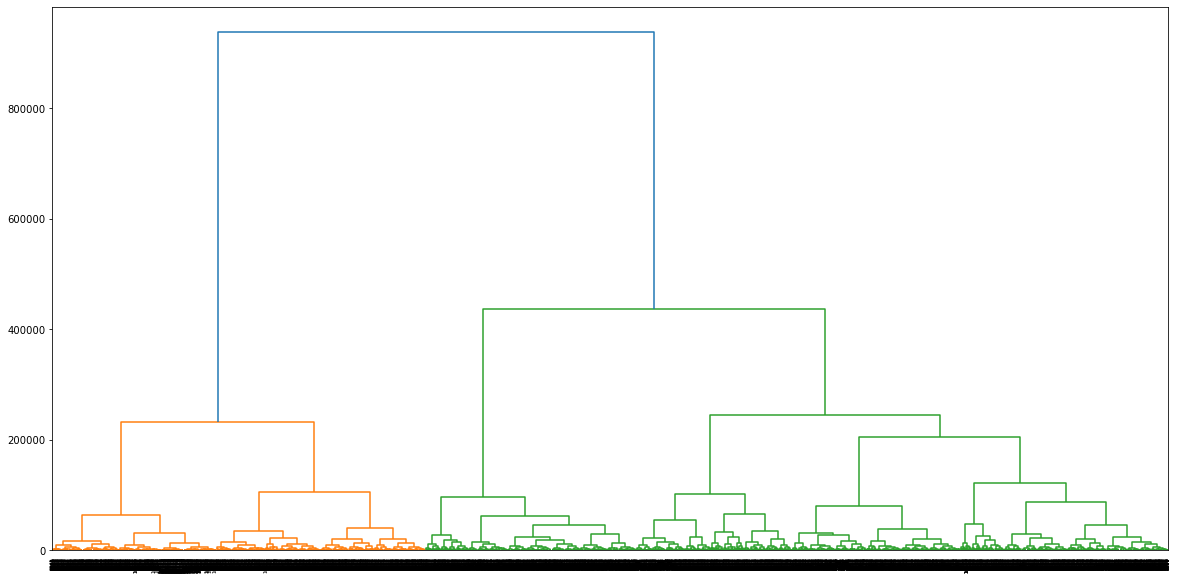

In [95]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy

aggclust = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
aggclust.fit(df_bert_final.drop(columns=['subreddit_x']))

print(f'Number of clusters: {aggclust.n_clusters_}')
print(f'Dendrogram distances: {aggclust.distances_}')

Z = hierarchy.linkage(aggclust.children_, 'ward')

plt.figure(figsize=(20,10))
dn = hierarchy.dendrogram(Z, leaf_rotation=90)

plt.savefig('Charts/12.jpg')

<font color='lightpurple'> The AC plot can be used to estimate the level of distinction between the 2 subreddits. From the above plot, we see that the blue line is the largest vertical difference, which indicates that there are 2 clusters. However, we do not know for sure whether these 2 clusters correspond to MST or Zoom. Nevertheless, the plot is useful in telling us that there are 2 distinct clusters. In fact, there could even be a sub-cluster within one of the clusters. 

### Further Data Exploration of Vectorized Text (t-SNE)

<font color='lightpurple'> One problem text analytics is that it's usually difficult if not impossible to visualise the spread of the data, since the text has been vectorized into so many dimensions (768 for BERT).
    
<font color='lightpurple'> t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique that is capable of dimensionality reduction and hence be able to visualise high dimension data. t-SNE shines over the traditional PCA method as PCA is a technique and is hence unable to capture non-linear patterns well, especially in high dimension space [(reference)](https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1). Since our vectorized text data is non-linear, t-SNE would be more appropriate as a dimensionality reduction tool.
    
<font color='lightpurple'> That said, a drawback of t-SNE is that unlike PCA, it is not able to "learn" from the data and be used subsequently on unseen data. Hence, we will use t-SNE only for visualisation of text vectors output from BERT.

In [141]:
from sklearn.manifold import TSNE

# Reduce 770 dimensions from BERT output to 3
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(df_bert_final.drop(['subreddit_x'],axis=1))

# Include labels
df_tsne = pd.concat([pd.DataFrame(z), df_bert_final['subreddit_x']], axis=1)
df_tsne['subreddit_x'] = df_tsne['subreddit_x'].map({0:'MicrosoftTeams', 1:'Zoom'})

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10284 samples in 0.009s...
[t-SNE] Computed neighbors for 10284 samples in 3.140s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10284
[t-SNE] Computed conditional probabilities for sample 2000 / 10284
[t-SNE] Computed conditional probabilities for sample 3000 / 10284
[t-SNE] Computed conditional probabilities for sample 4000 / 10284
[t-SNE] Computed conditional probabilities for sample 5000 / 10284
[t-SNE] Computed conditional probabilities for sample 6000 / 10284
[t-SNE] Computed conditional probabilities for sample 7000 / 10284
[t-SNE] Computed conditional probabilities for sample 8000 / 10284
[t-SNE] Computed conditional probabilities for sample 9000 / 10284
[t-SNE] Computed conditional probabilities for sample 10000 / 10284
[t-SNE] Computed conditional probabilities for sample 10284 / 10284
[t-SNE] Mean sigma: 0.871822
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.554779
[t-SNE] KL 

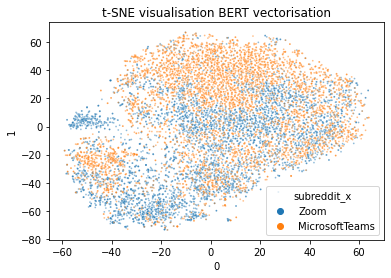

In [149]:
# Visualise t-SNE with plotly for 3D scatter plots

sns.scatterplot(data=df_tsne, x=0, y=1, hue="subreddit_x", alpha=0.5, s=3)
plt.title('t-SNE visualisation BERT vectorisation')
plt.savefig('Charts/13.jpg')

<font color='lightpurple'> From the above chart, we can see that the data is not very well distinguished in 2D space, although there are several noticeable clusters. If this distribution is representative of the actual distribution in multi-dimensional space, then linear classifiers such as Logistic Regression is expected to not perform well if the text is vectorized with BERT.

## Modeling

### Baseline Model

<font color='lightpurple'> The baseline model for this project would be a random classifier, which would predict either class with 50% probability. Thus, the accuracy score for this baseline model would be 50%. Our models should therefore strive to achieve a score significantly better than 50%.    

### Model Selection

<font color='lightpurple'> We will explore 3 different models - Logistic Regression, MultiLayer Perceptron (MLP) and Random Forest
    
<font color='lightpurple'> **Logistic Regression** assumes a linear relationship between the features and the target variable and converts the output into a value between 0 and 1 via the sigmoid function. It is considered a high bias-low variance model and may work well when the data is of high dimensions, as in our current project.
    
<font color='lightpurple'> **MLP** is a neural network consisting of an input layer, at least 1 hidden layer and an output layer. The neural network method of machine learning was adapted from neurons in the human brain (hence its name), where the brain is made up of many individual neurons linked together. Each neuron takes in an input and generates an output, which may feed to the adjacent neuron, thereby propagating the signal. Likewise, the MLP works by having many neurons (perceptrons) linked together. By adjusting the weights and the output function, the model can be tuned in a way to achieve the desired output. In our project, the desired output would be binary 1 or 0, hence the name MLP Classifier.
    
<font color='lightpurple'> **Random Forest** is made up of many decision trees, where each tree attempts to split the data based on the features. Starting from the full sample, each split involves a boolean question until some sort of stopping threshold is reached, for example, when all the leaves are pure. As expected, individual decision trees are poor learners but data scientists have found that by growing multiple trees and aggregating each tree's predictions, the ensemble model actually does a pretty good job.

In [188]:
lr = LogisticRegression()
mlp = MLPClassifier(max_iter = 1000, random_state=42)
rf = RandomForestClassifier()

results = []

def trainer(vectorizer, model):
    
    if vectorizer == 'tfvec':

        model.fit(tfvec_X_train, tfvec_y_train)
        train_score = model.score(tfvec_X_train, tfvec_y_train)
        test_score= model.score(tfvec_X_test, tfvec_y_test)
        
        return (vectorizer, model, train_score, test_score)

    elif vectorizer == 'w2v':

        model.fit(w2v_X_train, w2v_y_train)
        train_score = model.score(w2v_X_train, w2v_y_train)
        test_score= model.score(w2v_X_test, w2v_y_test)
        
        return (vectorizer, model, train_score, test_score)

    elif vectorizer == 'bert':

        model.fit(bert_X_train, bert_y_train)
        train_score = model.score(bert_X_train, bert_y_train)
        test_score= model.score(bert_X_test, bert_y_test)
        
        return (vectorizer, model, train_score, test_score)    

In [189]:
for vec in ['tfvec', 'w2v', 'bert']:
    print(f'{datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")}: Training LR on {vec} now')
    results.append(trainer(vec, lr))
    print(f'{datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")}: Training MLP on {vec} now')
    results.append(trainer(vec, mlp))
    print(f'{datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")}: Training RF on {vec} now')
    results.append(trainer(vec, rf))

31-12-2021 21:20:14: Training LR on tfvec now
31-12-2021 21:20:18: Training MLP on tfvec now
31-12-2021 21:25:57: Training RF on tfvec now
31-12-2021 21:26:19: Training LR on w2v now
31-12-2021 21:26:19: Training MLP on w2v now
31-12-2021 21:26:34: Training RF on w2v now
31-12-2021 21:26:41: Training LR on bert now


C:\HA\Python\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



31-12-2021 21:26:41: Training MLP on bert now
31-12-2021 21:27:30: Training RF on bert now


In [192]:
df_results = pd.DataFrame(results, columns = ['vectorizer', 'model', 'train_score', 'test_score'])
df_results

,vectorizer,model,train_score,test_score
0,tfvec,LogisticRegression(),0.969521,0.942251
1,tfvec,"MLPClassifier(max_iter=1000, random_state=42)",0.998984,0.906600
2,tfvec,"(DecisionTreeClassifier(max_features='auto', r...",0.999129,0.940483
3,w2v,LogisticRegression(),0.935362,0.919326
4,w2v,"MLPClassifier(max_iter=1000, random_state=42)",0.998981,0.922872
5,w2v,"(DecisionTreeClassifier(max_features='auto', r...",0.999127,0.904846
6,bert,LogisticRegression(),0.941800,0.917207
7,bert,"MLPClassifier(max_iter=1000, random_state=42)",0.999710,0.910725
8,bert,"(DecisionTreeClassifier(max_features='auto', r...",0.999710,0.873600


<font color='lightpurple'> Based on our initial run where default hyperparameters are used, we have already obtained a relatively good score, with most of our models scoring at least 90% accuracy.
    
<font color='lightpurple'> For tfvec, the best model is LogisicRegression, which is also the best out of all. For w2v, the best model is MLP while for bert, the best model is again LogisticRegression.
    
<font color='lightpurple'> Despite its simplicity, LogisticRegression does pretty well. This could be because due to the large number of features, our MLP and RF models overfitted to the data, as seen where the training score is significantly higher than the test score for these 2 models.
    
<font color='lightpurple'> Let's attempt to tune our models and see whether there is any change to our results.    

### Hyperparameter Tuning

In [256]:
lr_params = {
    'penalty': ['l1', 'l2'],
    'solver': ['saga', 'liblinear'],
    'C': [1, 0.1, 0.01, 0.001, 0.0001]
}

grid_lr = RandomizedSearchCV(LogisticRegression(random_state=42), param_distributions=lr_params, scoring='accuracy', verbose=1, cv=3, n_iter=20, random_state=42)

rf_params = {
    'n_estimators': [25,50,100,125,150],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'log2', None],
    'ccp_alpha': [0.001, 0.01, 0.1, 0]
}

grid_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=rf_params, scoring='accuracy', verbose=1, cv=3, n_iter=10, random_state=42)

mlp_params = {
    'hidden_layer_sizes': [(16,), (32,), (16,16), (16,16,16)],
    'alpha': [0.01, 0.001, 0.0001, 0.00001, 0.000001]
}

grid_mlp = RandomizedSearchCV(MLPClassifier(random_state=42), param_distributions=mlp_params, scoring='accuracy', verbose=1, cv=3, n_iter=5, random_state=42)

In [257]:
results_tuned = []

def hyperparameter_tuner(vectorizer, grid):
    
    if vectorizer == 'tfvec':

        grid.fit(tfvec_X_train, tfvec_y_train)
        
        return (vectorizer,grid.estimator, grid.best_score_, grid.best_params_) 
    
    elif vectorizer == 'w2v':

        grid.fit(w2v_X_train, w2v_y_train)
        
        return (vectorizer,grid.estimator, grid.best_score_, grid.best_params_) 
    
    elif vectorizer == 'bert':

        grid.fit(bert_X_train, bert_y_train)
        
        return (vectorizer,grid.estimator, grid.best_score_, grid.best_params_) 

In [258]:
for vec in ['tfvec', 'w2v', 'bert']:
    print(f'{datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")}: Gridsearching LR on {vec} now')
    results_tuned.append(hyperparameter_tuner(vec, grid_lr))
    print(f'{datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")}: Gridsearching MLP on {vec} now')
    results_tuned.append(hyperparameter_tuner(vec, grid_mlp))
    print(f'{datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")}: Gridsearching RF on {vec} now')
    results_tuned.append(hyperparameter_tuner(vec, grid_rf))

01-01-2022 01:48:26: Gridsearching LR on tfvec now
Fitting 3 folds for each of 20 candidates, totalling 60 fits
01-01-2022 01:58:28: Gridsearching MLP on tfvec now
Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\HA\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\HA\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\HA\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



01-01-2022 02:50:12: Gridsearching RF on tfvec now
Fitting 3 folds for each of 10 candidates, totalling 30 fits
01-01-2022 03:13:49: Gridsearching LR on w2v now
Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\HA\Python\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\HA\Python\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\HA\Python\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



01-01-2022 03:14:22: Gridsearching MLP on w2v now
Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\HA\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\HA\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\HA\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\HA\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\HA\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum

01-01-2022 03:15:29: Gridsearching RF on w2v now
Fitting 3 folds for each of 10 candidates, totalling 30 fits
01-01-2022 03:31:18: Gridsearching LR on bert now
Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\HA\Python\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\HA\Python\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\HA\Python\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\HA\Python\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\HA\Python\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\HA\Python\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\HA\Python\Anaconda\lib\site-packages\

01-01-2022 03:33:22: Gridsearching MLP on bert now
Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\HA\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\HA\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\HA\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\HA\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\HA\Python\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum

01-01-2022 03:36:39: Gridsearching RF on bert now
Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [259]:
df_results_tuned = pd.DataFrame(results_tuned, columns = ['vectorizer', 'model', 'best_score', 'best_params'])
df_results_tuned

,vectorizer,model,best_score,best_params
0,tfvec,LogisticRegression(random_state=42),0.941654,"{'solver': 'liblinear', 'penalty': 'l2', 'C': 1}"
1,tfvec,MLPClassifier(random_state=42),0.927430,"{'hidden_layer_sizes': (16,), 'alpha': 0.01}"
2,tfvec,RandomForestClassifier(random_state=42),0.939477,"{'n_estimators': 125, 'min_samples_split': 10,..."
3,w2v,LogisticRegression(random_state=42),0.916872,"{'solver': 'liblinear', 'penalty': 'l2', 'C': 1}"
4,w2v,MLPClassifier(random_state=42),0.911194,"{'hidden_layer_sizes': (16,), 'alpha': 0.01}"
5,w2v,RandomForestClassifier(random_state=42),0.896637,"{'n_estimators': 125, 'min_samples_split': 10,..."
6,bert,LogisticRegression(random_state=42),0.912335,"{'solver': 'liblinear', 'penalty': 'l2', 'C': 1}"
7,bert,MLPClassifier(random_state=42),0.906385,"{'hidden_layer_sizes': (16,), 'alpha': 0.01}"
8,bert,RandomForestClassifier(random_state=42),0.874455,"{'n_estimators': 125, 'min_samples_split': 10,..."


In [ ]:
from IPython.display import Audio 
Audio('C:/Windows/Media/Alarm01.wav', autoplay=True)

##### Is text data successfully converted to a matrix representation?

##### Are methods such as stop words, stemming, and lemmatization explored?

##### Does the student properly split and/or sample the data for validation/training purposes?

##### Does the student test and evaluate a variety of models to identify a production algorithm (AT MINIMUM: Random Forest and one other model)?

##### Does the student defend their choice of production model relevant to the data at hand and the problem?

##### Does the student explain how the model works and evaluate its performance successes/downfalls?

# Evaluation & Conceptual Understanding

##### Does the student accurately identify and explain the baseline score?

##### Does the student select and use metrics relevant to the problem objective?

##### Does the student interpret the results of their model for purposes of inference?

##### Is domain knowledge demonstrated when interpreting results?

##### Does the student provide appropriate interpretation with regards to descriptive and inferential statistics?

# Conclusions & Recommendations

##### Does the student provide appropriate context to connect individual steps back to the overall project?

##### Is it clear how the final recommendations were reached?

##### Are the conclusions/recommendations clearly stated?

##### Does the conclusion answer the original problem statement?

##### Does the student address how findings of this research can be applied for the benefit of stakeholders?

##### Are future steps to move the project forward identified?

In [28]:
# Concatenate all comments per submission, then join back to main submission

#zoom_c_grouped = zoom_c.groupby(['parent_id'])['body'].apply(lambda x: ' '.join(x)).reset_index()
#zoom = zoom_s.merge(zoom_c_grouped, how='left', left_on = 'id', right_on = 'parent_id').drop(['parent_id'], axis=1)
#print(zoom.shape)

#mst_c_grouped = mst_c.groupby(['parent_id'])['body'].apply(lambda x: ' '.join(x)).reset_index()
#mst = mst_s.merge(mst_c_grouped, how='left', left_on = 'id', right_on = 'parent_id').drop(['parent_id'], axis=1)
#print(mst.shape)

In [29]:
#print(datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"))

# First, for each row of text, vectorise it and find sentence vector by taking average of all word vectors
# The result is a pandas Series where the value of each row is a 300-d array
# Unpack the 300-d array such that each dimension is now one column in a dataframe

#spacy_X_train = pd.DataFrame(X_train.apply(lambda x: nlp(x).vector).values.tolist())
#print(f'Shape of spacy word2vec X_train: {spacy_X_train.shape}')

#print(datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"))

#spacy_X_test = pd.DataFrame(X_test.apply(lambda x: nlp(x).vector).values.tolist())
#print(f'Shape of spacy word2vec X_test: {spacy_X_test.shape}')

#print(datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"))

<font color='lightpurple'> Here, each row of text gave us 300 dimensions, or features. These features do not actually make sense on its own, hence whatever result we get from our machine learning model later on will not be useful anyway. For example, if we know dimension 23 has a large coefficient, but we do not know what dimension 23 is, hence is useless for explainability. Because of this, we might as well take the opportunity to reduce the number of dimensions with PCA.

In [30]:
#pca_test = PCA(n_components = 300)
#pca_test.fit(w2v_X_train.iloc[:, 2:])

#plt.plot(np.cumsum(np.round(pca_test.explained_variance_ratio_, decimals=4)*100))
#plt.title('Amount of explained variance versus number of principal components')
#plt.savefig('Charts/12.jpg')

In [31]:
#print(f'{sum(np.cumsum(np.round(pca_test.explained_variance_ratio_, decimals=4)*100) <= 90)} principal components explain 90% of the total variance')

<font color='lightpurple'> We will hence use 156 components as the hyperparamter in PCA

In [32]:
#pca_w2v = PCA(n_components = 156)
#pca_w2v.fit_transform(w2v_X_train.iloc[:, 2:])

In [3]:
# tfvec = TfidfVectorizer()

# tfvec_X_train, tfvec_X_test, tfvec_y_train, tfvec_y_test = train_test_split(df_tfidf[['ids', 'text_nostop']], df['subreddit'], test_size=0.33, random_state=42)

# tfvec_X_train_id = tfvec_X_train['ids'].reset_index(drop=True)

# # Vectorise text data
# tfvec_X_train_text = tfvec.fit_transform(tfvec_X_train['text_nostop'])
# print(f'Shape of tfidf X_train_text: {tfvec_X_train_text.shape}')

# # Add back in id column, since the order of the rows is the same
# tfvec_X_train_text_id = pd.concat([tfvec_X_train_id, 
#            pd.DataFrame(tfvec_X_train_text.todense(), columns=tfvec.get_feature_names())]
#           , axis=1)
# print(f'Shape of tfidf X_train_text_id: {tfvec_X_train_text_id.shape}')

# # Merge in comment data
# tfvec_X_train_final = tfvec_X_train_text_id.merge(cmts, how='left', left_on = 'ids', right_on = 'parent_id').drop(columns = ['subreddit_y', 'parent_id'])
# tfvec_X_train_final.fillna(0, inplace=True)
# print(f'Shape of tfidf X_train_final: {tfvec_X_train_final.shape}')
# print(f'Shape of tfidf y_train: {tfvec_y_train.shape}')
# ###################################################################################

# tfvec_X_test_id = tfvec_X_test['ids'].reset_index(drop=True)

# tfvec_X_test_text = tfvec.transform(tfvec_X_test['text_nostop'])
# print(f'Shape of tfidf X_test_text: {tfvec_X_test_text.shape}')

# tfvec_X_test_text_id = pd.concat([tfvec_X_test_id, 
#            pd.DataFrame(tfvec_X_test_text.todense(), columns=tfvec.get_feature_names())]
#           , axis=1)
# print(f'Shape of tfidf X_test_text_id: {tfvec_X_test_text_id.shape}')

# tfvec_X_test_final = tfvec_X_test_text_id.merge(cmts, how='left', left_on = 'ids', right_on = 'parent_id').drop(columns = ['subreddit_y', 'parent_id'])
# tfvec_X_test_final.fillna(0, inplace=True)
# print(f'Shape of tfidf X_test_final: {tfvec_X_test_final.shape}')
# print(f'Shape of tfidf y_test: {tfvec_y_test.shape}')

C:\HA\Python\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Shape of tfidf X_train_text: (6890, 13210)
Shape of tfidf X_train_text_id: (6890, 13211)
Shape of tfidf X_train_final: (6890, 13213)
Shape of tfidf y_train: (6890,)
Shape of tfidf X_test_text: (3394, 13210)
Shape of tfidf X_test_text_id: (3394, 13211)
Shape of tfidf X_test_final: (3394, 13213)
Shape of tfidf y_test: (3394,)


In [7]:
# w2v_vocab = set(w2v.index_to_key)

# # Word2Vec
# df_w2v = df[['ids', 'subreddit', 'text_nostop']]

# # Remove special chars
# df_w2v['text_nostop'] = df_w2v['text_nostop'].str.replace('[^0-9a-zA-Z\s]','')

# # Remove OOV words
# df_w2v['text_noOOV'] = df_w2v['text_nostop'].apply(lambda x: ' '.join([i for i in x.split() if i in w2v_vocab]))

# # Remove rows with blank string
# df_w2v = df_w2v[df_w2v.text_noOOV != ''].reset_index(drop=True)
# print(f'Shape of df_w2v: {df_w2v.shape}')

# # Vectorise text and store in new dataframe
# df_w2v_vectors = pd.DataFrame(df_w2v['text_noOOV'].apply(lambda x: np.mean([w2v[i] for i in x.split()], axis=0)).values.tolist())
# print(f'Shape of df_w2v_vectors: {df_w2v_vectors.shape}')

# # Merge df_w2v with comment statistics
# df_w2v_cmts = df_w2v.merge(cmts, how='left', left_on = 'ids', right_on = 'parent_id').drop(columns=['subreddit_y', 'parent_id'])
# df_w2v_cmts.fillna(0, inplace=True)
# print(f'Shape of df_w2v_vectors_cmts: {df_w2v_cmts.shape}')

# # Further merge in word vectors
# df_w2v_final = pd.concat([df_w2v_cmts, df_w2v_vectors], axis=1)
# print(f'Shape of df_w2v_final: {df_w2v_final.shape}')

<ipython-input-7-2d62602eb2f0>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_w2v['text_nostop'] = df_w2v['text_nostop'].str.replace('[^0-9a-zA-Z\s]','')
<ipython-input-7-2d62602eb2f0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w2v['text_nostop'] = df_w2v['text_nostop'].str.replace('[^0-9a-zA-Z\s]','')
<ipython-input-7-2d62602eb2f0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w2v['text_noOOV'] = df_w2v['text_nostop'].apply(lambda x: ' 

Shape of df_w2v: (10253, 4)
Shape of df_w2v_vectors: (10253, 300)
Shape of df_w2v_vectors_cmts: (10253, 6)
Shape of df_w2v_final: (10253, 306)


<font color='lightpurple'> As a result of removing OOV words, a few records turned out to be blank strings. These rows are thus dropped. This may result in slight unbalanced of classes, but is marginal.

In [8]:
# w2v_X_train, w2v_X_test, w2v_y_train, w2v_y_test = train_test_split(df_w2v_final.iloc[:, 4:], df_w2v_final['subreddit_x'], test_size=0.33, random_state=42)

# print(f'Shape of w2v_X_train: {w2v_X_train.shape}')
# print(f'Shape of w2v_y_train: {w2v_y_train.shape}')
# print(f'Shape of w2v_X_test: {w2v_X_test.shape}')
# print(f'Shape of w2v_y_test: {w2v_y_test.shape}')

Shape of w2v_X_train: (6869, 302)
Shape of w2v_y_train: (6869,)
Shape of w2v_X_test: (3384, 302)
Shape of w2v_y_test: (3384,)


In [14]:
# bert_dataset = CustomTextDataset(text = df_bert['text'], 
#                                  label = df_bert['subreddit'],
#                                  tokenizer = tokenizer,
#                                  max_len = 512
#                                 )
# bert_dataloader = DataLoader(bert_dataset, batch_size=2)

In [24]:
# %%time
# output_array = np.empty((0,768))

# for (idx, batch) in enumerate(bert_dataloader):
#     print(f'Batch {idx} started at {datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S")}')
#     ids = batch['ids'].squeeze()
#     mask = batch['mask'].squeeze()
    
#     with torch.no_grad():
#         output = model(ids, mask).last_hidden_state[:,0,:].numpy()
#         output_array = np.vstack((output_array, output))

Batch 0 started at 30-12-2021 10:34:50
Batch 1 started at 30-12-2021 10:34:51
Batch 2 started at 30-12-2021 10:34:52
Batch 3 started at 30-12-2021 10:34:53
Batch 4 started at 30-12-2021 10:34:53
Batch 5 started at 30-12-2021 10:34:54
Batch 6 started at 30-12-2021 10:34:55
Batch 7 started at 30-12-2021 10:34:56
Batch 8 started at 30-12-2021 10:34:56
Batch 9 started at 30-12-2021 10:34:57
Batch 10 started at 30-12-2021 10:34:58
Batch 11 started at 30-12-2021 10:34:59
Batch 12 started at 30-12-2021 10:35:00
Batch 13 started at 30-12-2021 10:35:00
Batch 14 started at 30-12-2021 10:35:01
Batch 15 started at 30-12-2021 10:35:02
Batch 16 started at 30-12-2021 10:35:03
Batch 17 started at 30-12-2021 10:35:04
Batch 18 started at 30-12-2021 10:35:04
Batch 19 started at 30-12-2021 10:35:05
Batch 20 started at 30-12-2021 10:35:06
Batch 21 started at 30-12-2021 10:35:07
Batch 22 started at 30-12-2021 10:35:08
Batch 23 started at 30-12-2021 10:35:08
Batch 24 started at 30-12-2021 10:35:09
Batch 25 s